## Exercise

Load the national COVID dataset and solve the exercise using `scikit-learn` library.
Consider first the column corresponding to the (cumulative) number of deaths. 
1. Perform a train-test split, with observations from the last week corresponding to the test set;
2. Build a suitable combination of kernels choosing from the ones shown in `notebook_05`;
3. Fit a `GaussianProcessRegressor` to predict the daily number of swabs, plot future predictions and compare them to real test data;
4. Repeat points 1-3 on the daily number of swabs, which can be computed from the cumulative number provided in the dataset.

You are welcome to try out and fit other data streams in the dataset. 


In [1]:
import numpy as np
from sklearn import gaussian_process
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mt
import os
import pandas as pd
import datetime as dt

mt.rcParams['axes.titlesize'] = 20
mt.rcParams['axes.labelsize'] = 16
mt.rcParams['xtick.labelsize'] = 12
mt.rcParams['ytick.labelsize'] = 12
mt.rcParams['legend.fontsize'] = 14

* 1. **Solution**

    I load the dataset from `data` folder and I set the `date` as the index of the dataframe

In [2]:
# Load the monthly dataset
data_covid = pd.read_csv("data/COVID_national_20200421.csv")

# fix column names
cols = list(data_covid.columns[data_covid.columns != 'Unnamed: 0'])
data_covid = data_covid[cols]

# drop rows with nan
data_covid.dropna(inplace=True)

# set date as index
data_covid['date'] = pd.to_datetime(data_covid['date'])
data_covid = data_covid.set_index('date', drop=True)


data_covid.head()

,deaths,swabs,ICU,hospitalized,new_infections,cumulative_infections,recovered,quarantined
date,,,,,,,,
2020-02-24,7,4324,26,101,221,229,1,94
2020-02-25,10,8623,35,114,93,322,1,162
2020-02-26,12,9587,36,128,78,400,3,221
2020-02-27,17,12014,56,248,250,650,45,284
2020-02-28,21,15695,64,345,238,888,46,412


In [3]:
# Helpful functions

def dates_to_idx(timelist):
    reference_time = pd.to_datetime('2020-02-24')
    t = (timelist - reference_time) / pd.Timedelta(1, "D")
    return np.asarray(t)

def idx_to_date(time_index):
    reference_time = pd.to_datetime('2020-02-24')
    date=[[reference_time+pd.Timedelta(time_index[i], "D")] for i in range(len(time_index))]
    return np.array(date)



Since our analysis is focused on daily swabs analysis, inside the `data_covid` dataframe I add two columns:

   * `t`: which represents the number of day after the first day, that was the 24-02-2020.

* `daily_swabs`: which represents the number of daily swabs; it is simply computed by subracting the current number of swabs with the previous one.


In [4]:
t = dates_to_idx(data_covid.index)

# log-scale
y = data_covid["swabs"].values
daily_swabs = [y[0] if i==0 else y[i]-y[i-1] for i in range(len(y))]
y_n = daily_swabs

data_covid = data_covid.assign(t = t)
data_covid = data_covid.assign(daily_swab = daily_swabs)


data_covid.head()

,deaths,swabs,ICU,hospitalized,new_infections,cumulative_infections,recovered,quarantined,t,daily_swab
date,,,,,,,,,,
2020-02-24,7,4324,26,101,221,229,1,94,0.0,4324
2020-02-25,10,8623,35,114,93,322,1,162,1.0,4299
2020-02-26,12,9587,36,128,78,400,3,221,2.0,964
2020-02-27,17,12014,56,248,250,650,45,284,3.0,2427
2020-02-28,21,15695,64,345,238,888,46,412,4.0,3681


In order to make the split between **train** and **test** data, I decide to train my model with the data that comes from the dataframe till the date 2020-04-13.

I store the dataframe relative to the train set in `data train`:

In [5]:
# index relative to 2020-04-13
sep_idx = data_covid.index.searchsorted(pd.to_datetime("2020-04-13"))

#dataframe of train set
data_train = data_covid.iloc[:sep_idx+1, :]

data_train.head(3)

,deaths,swabs,ICU,hospitalized,new_infections,cumulative_infections,recovered,quarantined,t,daily_swab
date,,,,,,,,,,
2020-02-24,7,4324,26,101,221,229,1,94,0.0,4324
2020-02-25,10,8623,35,114,93,322,1,162,1.0,4299
2020-02-26,12,9587,36,128,78,400,3,221,2.0,964


while the dataset relatives to the days after the 13-04-2020 are stored inside `data_test`:

In [6]:
#dataframe relative to test-set
data_test = data_covid.iloc[sep_idx:, :]

data_test.head(3)

,deaths,swabs,ICU,hospitalized,new_infections,cumulative_infections,recovered,quarantined,t,daily_swab
date,,,,,,,,,,
2020-04-13,20465,1046910,3260,28023,3153,159516,35435,72333,49.0,36717
2020-04-14,21067,1073689,3186,28011,2972,162488,37130,73094,50.0,26779
2020-04-15,21645,1117404,3079,27643,2667,165155,38092,74696,51.0,43715


* 2,3: **Solution**:

Since we are interested on fitting the number of daily swabs during time, let's have a graphical view of this dataset

Text(0.5,1,'daily swabs as a function of time index')

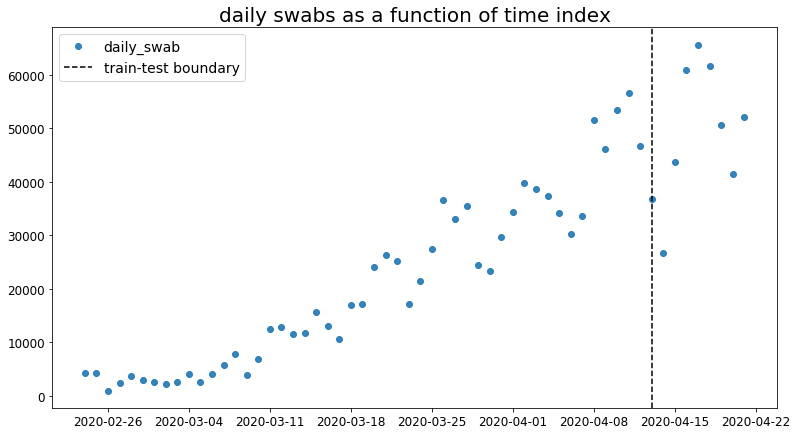

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))

ax.plot(data_covid.index, data_covid.daily_swab, marker='o', linestyle='', alpha=0.9)
ax.axvline(pd.to_datetime("2020-04-13"), linestyle='--', color='k', label="train-test boundary")
ax.legend()
ax.set_title('daily swabs as a function of time index')

The daily number of swabs looks to have a linear increasing during time but with some periodic behaviour inside very brief time intervals (5~7 days). 

In order to build a suitable kernel that might fit `daily_swabs`, let's check if the data have these property of linearity and periodicity.

In order to check if linearity can be a good hypotesis, I decide fit a simple linear regression just calling the ``LinearRegression`` function provided by `sklearn` library:

Text(0.5,1,'Daily swabs as a function of time index')

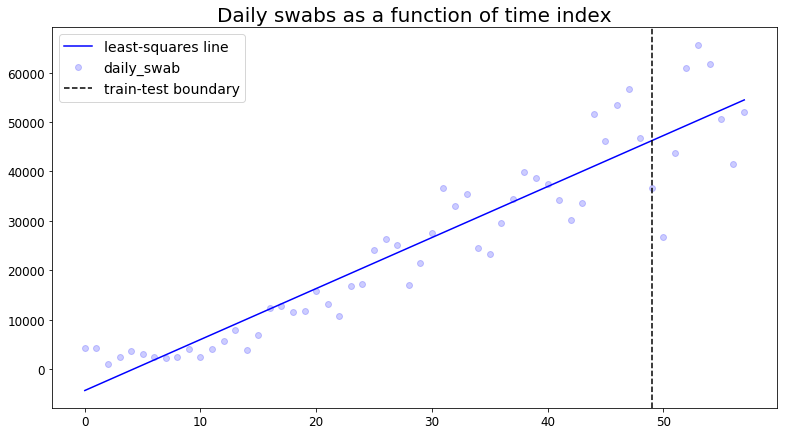

In [10]:
from sklearn.linear_model import LinearRegression

X = data_covid.t.values[:, None]
y = data_covid.daily_swab.values
train_X = X[:len(data_train)]
train_y = y[:len(data_train)]
test_X = X[len(data_train):]
test_y = y[len(data_train):]


reg = LinearRegression().fit(train_X, train_y)
retta = reg.intercept_ + np.dot(X,reg.coef_)


fig, ax = plt.subplots(1, 1, figsize=(13, 7))

ax.plot(data_covid.t.values, retta, color='b', label = 'least-squares line')
ax.plot(data_covid.t.values, data_covid.daily_swab, color='b', marker='o', linestyle='', alpha=0.2)
ax.axvline(dates_to_idx(pd.to_datetime("2020-04-13")), linestyle='--', color='k', label="train-test boundary")
ax.legend()
ax.set_title('Daily swabs as a function of time index')

As we can visualize, the data seems to have this general tendency to increase linearly over time

Taking the least square line as a really raw estimate of this linear increasing, I consider the residuals from the least-square line on the daily swabs taken every Monday from 09-03-2020: 

In [11]:
data_covid.daily_swab[14:len(daily_swabs):7] - retta[14:len(daily_swabs):7]

date
2020-03-09    -6207.390588
2020-03-16    -4261.263529
2020-03-23    -7486.136471
2020-03-30    -8451.009412
2020-04-06    -8736.882353
2020-04-13    -9518.755294
2020-04-20   -11980.628235
Name: daily_swab, dtype: float64

All residuals of swabs taken every 7 days seems to have (at first order) a similar negative value. This can be explained by some periodic phenomena that seems to happen during 7 days, while the absolute number of swabs has costant increasing. 

**Thus, the daily number of swabs has a steady upward trend with a 7-days effect of periodicity** .

These will be my general assumptions in order to build a proper kernel.

In [12]:
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, DotProduct, RBF, ExpSineSquared, RationalQuadratic, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

In [13]:
#plot gaussian process result

def plot_predictions(gp, include_observed=True):
    pred_y, pred_std = gp.predict(X, return_std=True)
    plt.figure(figsize=(10, 5))
    x = X[:, 0]
    if include_observed:
        plt.plot(x, y, 'ok', alpha=0.1)
    l, = plt.plot(x, pred_y)
    plt.fill_between(x,
                     pred_y + pred_std,
                     pred_y - pred_std,
                     color=l.get_color(), alpha=0.3)
    if np.allclose(X[:, 0], data_covid.t.values):
        plt.axvline(dates_to_idx(pd.to_datetime("2020-04-13")), linestyle='--', color='k')
    else:
        plt.axvline(pd.to_datetime("2020-04-13"), linestyle='--', color='k')

In [88]:
# train and test sets

X = data_covid.t.values[:, None]
y = data_covid.daily_swab.values
train_X = X[:len(data_train)]
train_y = y[:len(data_train)]
test_X = X[len(data_test):]
test_y = y[len(data_test):]

The first kernel that I decide to use is a `DotProduct` kernel, combined with a `WhiteKernel`. As it can be seen from the [documentation](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes), the combination of these two will produce a linear model with a noise-component. 

The choice of the hyperparameters is based on the fact that `GaussianProcessRegressor` used an optimizer.

Then, starting from initial arbitrary values of `sigma_0` and `noise_level` I repeated several times the fitting procedure and during every iteration I used optimized values of those hyperparameters given by the previous fit. I reapeat this procedure till the optimizer will give the same values  of `sigma_0` and `noise_level` given at the input

316**2
* DotProduct(sigma_0=77.7) + 86.7**2
* WhiteKernel(noise_level=6.26e+03)


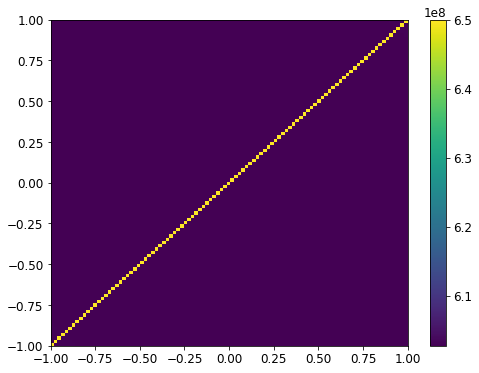

In [76]:
k1 = 316**2 * DotProduct(sigma_0=77.7) + 86.7**2 * WhiteKernel(noise_level=6.26e+03)

kernel = k1

vals = kernel(x[:, None])
plt.figure(figsize=(8, 6))
plt.pcolor(x, x, vals.reshape((len(x), len(x))))
print(str(kernel).replace(' *', '\n*'))
plt.colorbar();

In [32]:
k1 = 316**2 * DotProduct(sigma_0=77.7) + 86.7**2 * WhiteKernel(noise_level=6.26e+03)

kernel =  k1

# Create the regressor
gp0 = GaussianProcessRegressor(kernel=kernel, alpha=0.01,
                               normalize_y=True,
                               n_restarts_optimizer=3)
# Train the regressor
gp0.fit(train_X, train_y)

print("Kernel before: ", gp0.kernel)
print(" ")
print("Kernel after: ", gp0.kernel_)
print(" ")
print("Marginal likelihood value: ", gp0.log_marginal_likelihood_value_)
print(" ")

# The fitted kernel's parameters are packed into an array
print("Theta: ", gp0.kernel_.theta)

Kernel before:  316**2 * DotProduct(sigma_0=77.7) + 86.7**2 * WhiteKernel(noise_level=6.26e+03)
 
Kernel before:  316**2 * DotProduct(sigma_0=77.7) + 71.9**2 * WhiteKernel(noise_level=5.58e+03)
 
Parameters: {'alpha': 0.01, 'copy_X_train': True, 'kernel__k1': 316**2 * DotProduct(sigma_0=77.7), 'kernel__k2': 86.7**2 * WhiteKernel(noise_level=6.26e+03), 'kernel__k1__k1': 316**2, 'kernel__k1__k2': DotProduct(sigma_0=77.7), 'kernel__k1__k1__constant_value': 99856, 'kernel__k1__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k1__k2__sigma_0': 77.7, 'kernel__k1__k2__sigma_0_bounds': (1e-05, 100000.0), 'kernel__k2__k1': 86.7**2, 'kernel__k2__k2': WhiteKernel(noise_level=6.26e+03), 'kernel__k2__k1__constant_value': 7516.89, 'kernel__k2__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k2__k2__noise_level': 6260.0, 'kernel__k2__k2__noise_level_bounds': (1e-05, 100000.0), 'kernel': 316**2 * DotProduct(sigma_0=77.7) + 86.7**2 * WhiteKernel(noise_level=6.26e+03), 'n_restarts_optimiz

316**2 * DotProduct(sigma_0=77.7) + 71.9**2 * WhiteKernel(noise_level=5.58e+03)


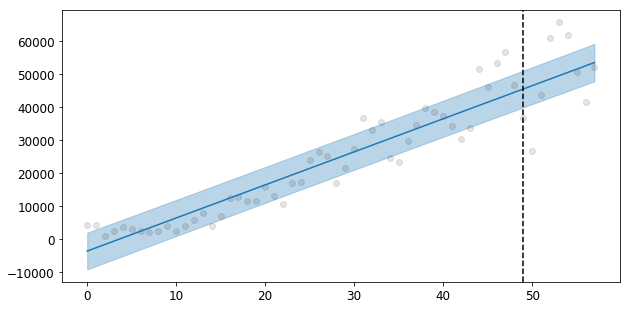

In [33]:
plot_predictions(gp0)
print(str(gp0.kernel_))

As it can be observed from  the result, this kernel produce the same model that I did using `LinearRegression`

Now I decide to add a kernel component that wants to represent the periodicity behaviour that I observed before. Looking to the [documentation](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes), I think that ExpSineSquared(), since it is used for modeling periodic functions, can model this kind of pattern.

For what concerns its hyperparameters, since there was observed a 7-days periodicity I fixed `periodicity=7.0`. On the other hand, the choice of `length_scale` is taken using the same procedure that I did on using the hyperparameters of the first kernel.

316**2
* DotProduct(sigma_0=77.7) + 86.7**2
* WhiteKernel(noise_level=6.26e+03)
* ExpSineSquared(length_scale=3.26, periodicity=7)


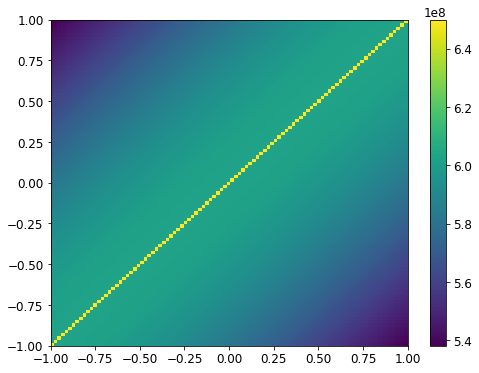

In [75]:
k1 = 316**2 * DotProduct(sigma_0=77.7) + 86.7**2 * WhiteKernel(noise_level=6.26e+03)
k2 = ExpSineSquared(length_scale=3.26,periodicity=7.0, periodicity_bounds="fixed")

kernel =  k1*k2

vals = kernel(x[:, None])
plt.figure(figsize=(8, 6))
plt.pcolor(x, x, vals.reshape((len(x), len(x))))
print(str(kernel).replace(' *', '\n*'))
plt.colorbar();

In [77]:
k1 = 316**2 * DotProduct(sigma_0=47.2) + 65.1**2 * WhiteKernel(noise_level=3.53e+03)
k2 = ExpSineSquared(length_scale=3.26,periodicity=7.0, periodicity_bounds="fixed")

kernel =  k1*k2

# Create the regressor
gp0 = GaussianProcessRegressor(kernel=kernel, alpha=0.01,
                               normalize_y=True,
                               n_restarts_optimizer=3)
# Train the regressor
gp0.fit(train_X, train_y)

print("Kernel before: ", gp0.kernel)
print(" ")
print("Kernel after: ", gp0.kernel_)
print(" ")
print("Marginal likelihood value: ", gp0.log_marginal_likelihood_value_)
print(" ")

# The fitted kernel's parameters are packed into an array
print("Theta: ", gp0.kernel_.theta)

Kernel before:  316**2 * DotProduct(sigma_0=47.2) + 65.1**2 * WhiteKernel(noise_level=3.53e+03) * ExpSineSquared(length_scale=3.26, periodicity=7)
 
Kernel after:  316**2 * DotProduct(sigma_0=47.2) + 65.1**2 * WhiteKernel(noise_level=3.53e+03) * ExpSineSquared(length_scale=3.26, periodicity=7)
 


316**2 * DotProduct(sigma_0=47.2) + 65.1**2 * WhiteKernel(noise_level=3.53e+03) * ExpSineSquared(length_scale=3.26, periodicity=7)


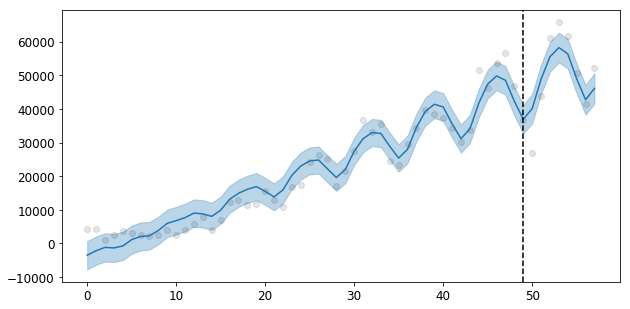

In [78]:
plot_predictions(gp0)
print(str(gp0.kernel_))

This kernel seems to follow the behaviour of daily swabs. However there are some points that look to be out of this regular fit seems to be a very raw aproximation on what is the real behaviour between daily swabs and time; I am not taking into account many factors that could lead to a number of swabs that can be different from the one predicted to this model.

In order to predict these irregularities, using as reference the [Mauna Loa example](https://github.com/lucianopaz/statistical_machine_learning/blob/master/notebooks/Gaussian%20processes%20tutorial.ipynb), I decide to use a `RationalQuadratic` as third kernel. Like I did before, the choice of hyperparameters is based on multiple fits of this gaussian process till I arrive to a stable choice of these.

316**2
* DotProduct(sigma_0=47.2) + 65.1**2
* WhiteKernel(noise_level=3.53e+03)
* ExpSineSquared(length_scale=4.02, periodicity=7)
* 2.49**2
* RationalQuadratic(alpha=9.98e+04, length_scale=54.1)


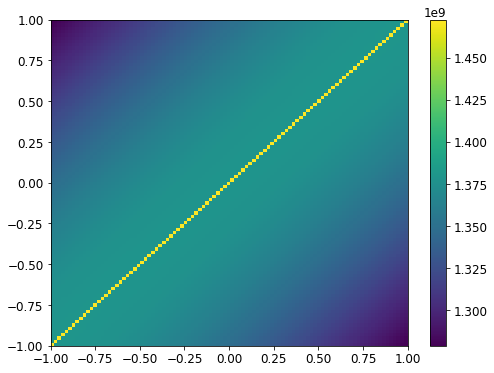

In [79]:
k1 = 316**2 * DotProduct(sigma_0=47.2) + 65.1**2 * WhiteKernel(noise_level=3.53e+03)
k2 = ExpSineSquared(length_scale=4.02, periodicity=7.0, periodicity_bounds="fixed") 
#+ 0.451**2 * WhiteKernel(noise_level=0.173)
k3 =  2.49**2 * RationalQuadratic(alpha=9.98e+04, length_scale=54.1)

kernel =  k1*k2*k3

vals = kernel(x[:, None])
plt.figure(figsize=(8, 6))
plt.pcolor(x, x, vals.reshape((len(x), len(x))))
print(str(kernel).replace(' *', '\n*'))
plt.colorbar();

In [82]:
k1 = 316**2 * DotProduct(sigma_0=47.2) + 65.1**2 * WhiteKernel(noise_level=3.53e+03)
k2 = ExpSineSquared(length_scale=4.02, periodicity=7.0, periodicity_bounds="fixed") 
k3 =  2.49**2 * RationalQuadratic(alpha=9.98e+04, length_scale=54.1)

kernel =  k1*k2*k3

# Create the regressor
gp0 = GaussianProcessRegressor(kernel=kernel, alpha=0.01,
                               normalize_y=True,
                               n_restarts_optimizer=3)
# Train the regressor
gp0.fit(train_X, train_y)

print("Kernel before: ", gp0.kernel)
print(" ")
print("Kernel after: ", gp0.kernel_)
print(" ")
print("Marginal likelihood value: ", gp0.log_marginal_likelihood_value_)
print(" ")

# The fitted kernel's parameters are packed into an array
print("Theta: ", gp0.kernel_.theta)

Kernel before:  316**2 * DotProduct(sigma_0=47.2) + 65.1**2 * WhiteKernel(noise_level=3.53e+03) * ExpSineSquared(length_scale=4.02, periodicity=7) * 2.49**2 * RationalQuadratic(alpha=9.98e+04, length_scale=54.1)
 
Kernel after:  316**2 * DotProduct(sigma_0=16.9) + 37**2 * WhiteKernel(noise_level=1.14e+03) * ExpSineSquared(length_scale=4.02, periodicity=7) * 2.32**2 * RationalQuadratic(alpha=9.98e+04, length_scale=54.1)
 
Marginal likelihood value:  -486.8948860759503
 
Theta:  [11.51292546  2.8278051   7.22440317  7.04160722  1.39166606  1.68688523
 11.51093355  3.99021389]


316**2 * DotProduct(sigma_0=16.9) + 37**2 * WhiteKernel(noise_level=1.14e+03) * ExpSineSquared(length_scale=4.02, periodicity=7) * 2.32**2 * RationalQuadratic(alpha=9.98e+04, length_scale=54.1)


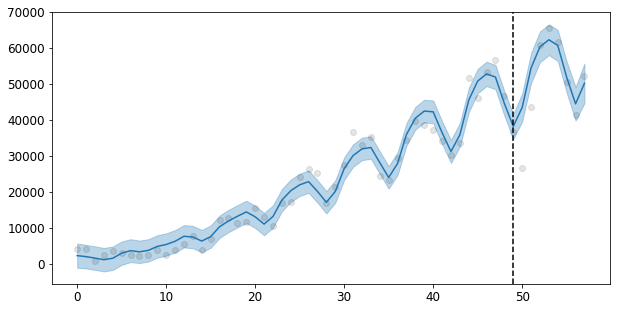

In [83]:
plot_predictions(gp0)
print(str(gp0.kernel_))

Given this model, I check now what is its behaviour along new data:

I load a new data-set from the [Dati COVID-19 Italia repository](https://github.com/pcm-dpc/COVID-19) in order to see if our model is able to predict new values of daily swabs

In [86]:
# Load the monthly dataset
data_covid_new = pd.read_csv("data/dpc-covid19-ita-andamento-nazionale.csv")

# fix column names
cols_new = list(data_covid_new.columns[data_covid_new.columns != 'Unnamed: 0'])
data_covid_new = data_covid_new[cols_new]

# set date as index
data_covid_new['data'] = pd.to_datetime(data_covid_new['data'])
data_covid_new = data_covid_new.set_index('data', drop=True)

t_new = dates_to_idx(data_covid_new.index)

# log-scale
y_new = data_covid_new["tamponi"].values
daily_swabs_new = [y_new[0] if i==0 else y_new[i]-y_new[i-1] for i in range(len(y_new))]
y_n_new = daily_swabs_new

data_covid_new = data_covid_new.assign(t = t_new)
data_covid_new = data_covid_new.assign(daily_swabs = daily_swabs_new)


data_covid_new.head(2)

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en,Unnamed: 16,Unnamed: 17,t,daily_swabs
data,,,,,,,,,,,,,,,,,,,
2020-02-24,ITA,101,26,127,94,221,0,221,1,7,229,4324,NaN,NaN,NaN,NaN,NaN,0.0,4324
2020-02-25,ITA,114,35,150,162,311,90,93,1,10,322,8623,NaN,NaN,NaN,NaN,NaN,1.0,4299


Text(0.5,1,'Daily wabs as a function of time')

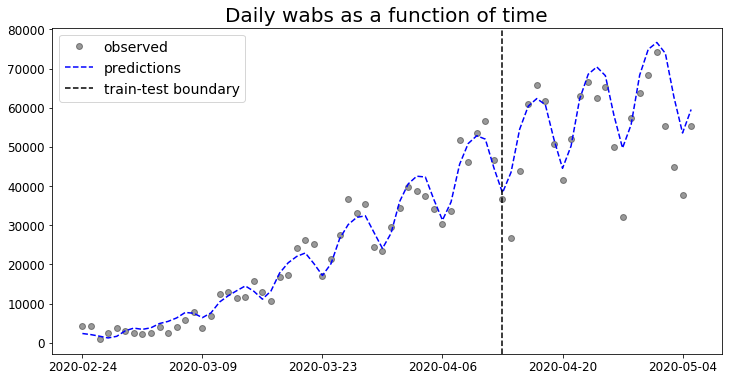

In [84]:
date_idx = np.array([[t_new[i]] for i in range(0,len(t_new))])
Y_hat = (gp0.predict(date_idx))


fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(data_covid_new.index.values,data_covid_new.daily_swabs.values, color='black', marker='o', linestyle='', alpha= 0.4,label='observed')
ax.plot(data_covid_new.index.values, Y_hat, color='b', linestyle='--', label="predictions")
ax.axvline(pd.to_datetime("2020-04-13"), linestyle='--', color='k', label="train-test boundary")
ax.legend()
ax.set_title('Daily wabs as a function of time')

Looking to the test region, it can be observed that during the first days after 04-13-2020 the qualitative behaviour of the points still remains true and the gaussian process with the last choice of the kernel is quite able to predict the number of daily swabs. However, going forward the irregularities become more relevant, expecially for the minimum point of daily swabs in each period of time, and the model is not quite precise. This is due to the fact that nowadays there are a lot of new circumstances that during our fit (that is done till 04-13-2020) I didn't take into account. 

Thus the suggestion that I can do at the end of this analysis can be to train the Gaussian Process with a higher number of points because only in this case we would be able to detect such new irregularities

* 4: **Solution**

I focus now the analysis on the cumulative number of swabs

Text(0.5,1,'Cumulative number of swabs')

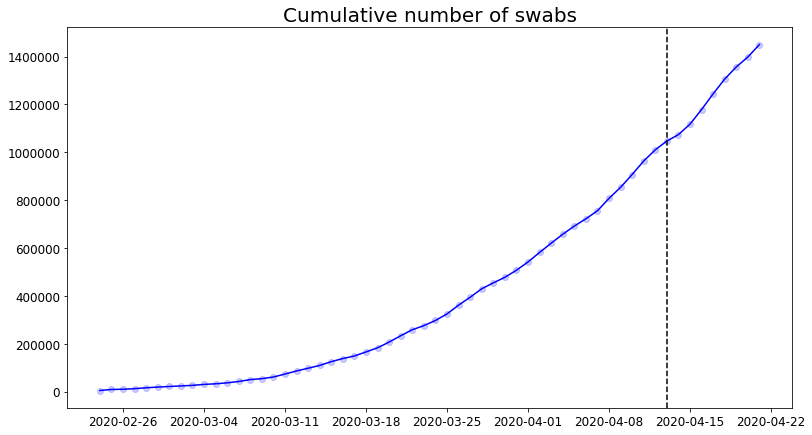

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))

ax.plot(data_covid.index.values, data_covid.swabs, color='b')
ax.plot(data_covid.index.values, data_covid.swabs, color='b', marker='o', linestyle='', alpha=0.2)
ax.axvline("2020-04-13", linestyle='--', color='k')
#ax.legend()
ax.set_title('Cumulative number of swabs')

In [91]:
X = data_covid.t.values[:, None]
y = data_covid.swabs.values
train_X = X[:len(data_train)]
train_y = y[:len(data_train)]
test_X = X[len(data_test):]
test_y = y[len(data_test):]

From what can be observed above, the cumulative number of swabs looks to have a parabolical behaviour.
Assuming this, as a choice of the first kernel I select a `DotProduct()**2`:

As I did before, the choice of the hyperparameter `sigma_0` is done in such a way to take the optimized value.

316**2
* DotProduct(sigma_0=15.8)
** 2


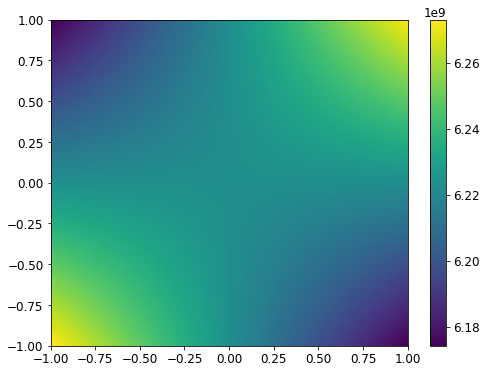

In [196]:
k1 = 316**2*DotProduct(sigma_0=15.8)**2

kernel = k1

vals = kernel(x[:, None])
plt.figure(figsize=(8, 6))
plt.pcolor(x, x, vals.reshape((len(x), len(x))))
print(str(kernel).replace(' *', '\n*'))
plt.colorbar();

In [197]:
# Create the regressor
gp0 = GaussianProcessRegressor(kernel=kernel, alpha=0.01,
                               normalize_y=True,
                               n_restarts_optimizer=3)
# Train the regressor
gp0.fit(train_X, train_y)

print("Kernel before: ", gp0.kernel)
print(" ")
print("Kernel after: ", gp0.kernel_)
print(" ")
print("Marginal likelihood value: ", gp0.log_marginal_likelihood_value_)
print(" ")

# The fitted kernel's parameters are packed into an array
print("Theta: ", gp0.kernel_.theta)

Kernel before:  316**2 * DotProduct(sigma_0=15.8) ** 2
 
Kernel after:  316**2 * DotProduct(sigma_0=15.8) ** 2
 
Marginal likelihood value:  -209158643859.904
 
Theta:  [11.51148443  2.76000994]


/home/roberto/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


316**2 * DotProduct(sigma_0=15.8) ** 2


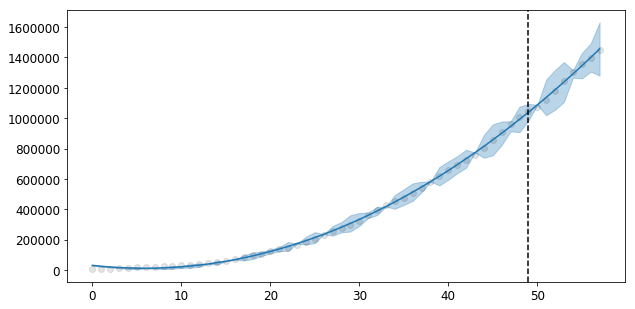

In [200]:
plot_predictions(gp0)
print(str(gp0.kernel_))

The kernel seems to approximate quite well our data, but there are some irregularities that seems to be due to their random nature.

In order to model this feature, I decide to add to ``DotProduct**2`` a ``WhiteKernel`` which has the aim to modelize the noise of the signal.

316**2
* DotProduct(sigma_0=27.9)
** 2 + 97.2**2
* WhiteKernel(noise_level=9.44e+03)


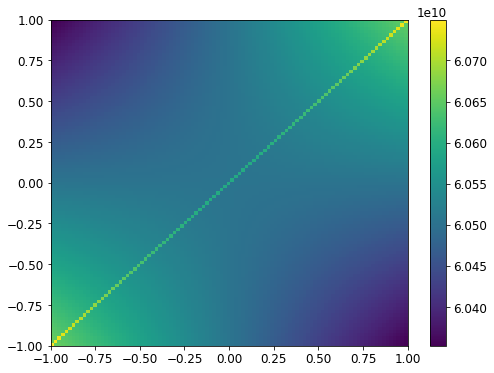

In [201]:
k1 = 316**2 * DotProduct(sigma_0=27.9)**2
k2 = 97.2**2 * WhiteKernel(noise_level=9.44e+03)
kernel = k1+k2

vals = kernel(x[:, None])
plt.figure(figsize=(8, 6))
plt.pcolor(x, x, vals.reshape((len(x), len(x))))
print(str(kernel).replace(' *', '\n*'))
plt.colorbar();

In [202]:
# Create the regressor
gp0 = GaussianProcessRegressor(kernel=kernel, alpha=0.01,
                               normalize_y=True,
                               n_restarts_optimizer=3)
# Train the regressor
gp0.fit(train_X, train_y)

print("Kernel before: ", gp0.kernel)
print(" ")
print("Kernel after: ", gp0.kernel_)
print(" ")
print("Marginal likelihood value: ", gp0.log_marginal_likelihood_value_)
print(" ")

# The fitted kernel's parameters are packed into an array
print("Theta: ", gp0.kernel_.theta)

Kernel before:  316**2 * DotProduct(sigma_0=27.9) ** 2 + 97.2**2 * WhiteKernel(noise_level=9.44e+03)
 
Kernel after:  316**2 * DotProduct(sigma_0=27.9) ** 2 + 97.2**2 * WhiteKernel(noise_level=9.44e+03)
 
Marginal likelihood value:  -543.36451223703
 
Theta:  [11.51292546  3.32902763  9.1538397   9.15300953]


316**2 * DotProduct(sigma_0=27.9) ** 2 + 97.2**2 * WhiteKernel(noise_level=9.44e+03)


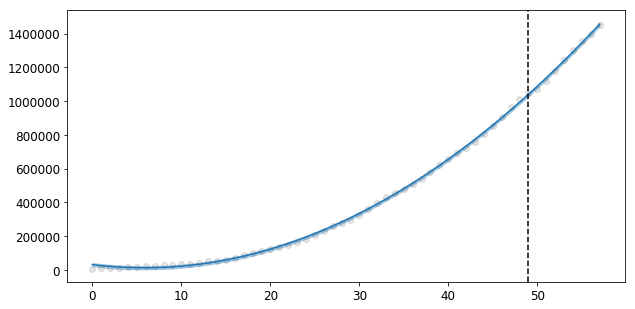

In [203]:
plot_predictions(gp0)
print(str(gp0.kernel_))

Like in the last point, let's now compare our model to the new dataset `dpc-covid19-ita-andamento-nazionale.csv` that encloses new measures of swabs till the 05-05-2002 day.

Text(0.5,1,'Daily wabs as a function of time')

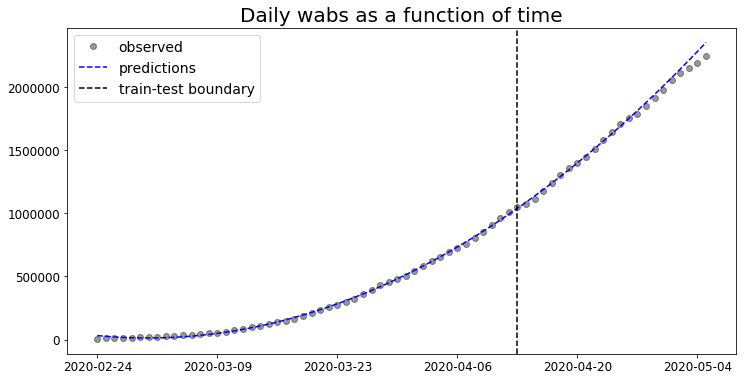

In [204]:
date_idx = np.array([[t_new[i]] for i in range(0,len(t_new))])
Y_hat = (gp0.predict(date_idx))


fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(data_covid_new.index.values,data_covid_new.tamponi.values, color='black', marker='o', linestyle='', alpha= 0.4,label='observed')
ax.plot(data_covid_new.index.values, Y_hat, color='b', linestyle='--', label="predictions")
ax.axvline(pd.to_datetime("2020-04-13"), linestyle='--', color='k', label="train-test boundary")
ax.legend()
ax.set_title('Daily wabs as a function of time')